# Projet - Real or Not? NLP with Disaster Tweets

## Project description 

* Competition - https://www.kaggle.com/c/nlp-getting-started

L'objectif de cette compétition Kaggle est de définir les tweet Disaster (catastrohpe). 

In [1]:
#Module installation 

!pip install spacy -q

In [2]:
# Initialization 

#Standard 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

#Model
import tensorflow as tf 
import tensorflow_datasets as tfds
import pathlib 

tf.__version__

'2.7.0'

In [4]:
#Load dataset & Read extract


dataset = pd.read_csv('datasets/Disaster_train.csv')

display(dataset.head())
display(dataset.shape)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


(7613, 5)

Les données sont composées de : 
- ID : identifiant unique du tweet
- keyword : Mot-clé à ajouter (si besoin)
- location : Localisation du tweet (peut être vide)
- text : corpus 
- target : Objectif de classification

In [5]:
# Basic stats
print("Number of rows : {}".format(dataset.shape[0]))
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()
print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])

Number of rows : 7613

Basics statistics: 


,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000



Percentage of missing values: 


id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

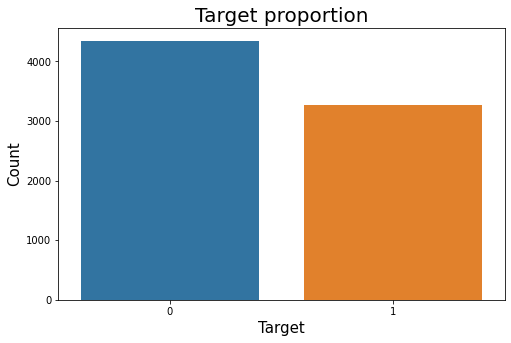

In [6]:
#Dataviz for the targer (proportion)
plt.figure(figsize=(8,5))
sns.countplot(x=dataset['target'])
plt.title('Target proportion',fontsize=20)
plt.xlabel('Target',fontsize=15)
plt.ylabel('Count',fontsize=15);

In [7]:
#Read texts 
display(dataset.loc[0,"text"])
display(dataset.loc[10,"text"])
display(dataset.loc[20,"text"])
display(dataset.loc[30,"text"])
display(dataset.loc[40,"text"])

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

'Three people died from the heat wave so far'

'this is ridiculous....'

'The end!'

'Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw'

In [8]:
#Create dataset with ID, text and target
disaster = dataset.drop(columns=["keyword","location"])
disaster.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
#Check word with "#" and "@"

SYMBOL1 = "#"
words_sym1 = [word for word in disaster["text"] if word.startswith(SYMBOL1)]
display(print(f"# {len(words_sym1)}"))
SYMBOL2 = "@"
words_sym2 = [word for word in disaster["text"] if word.startswith(SYMBOL2)]
display(print(f"@ {len(words_sym2)}"))

# 396


None

@ 1347


None

In [10]:
#Preprocessing NLP (case, html element, special characters)
disaster['text_cleaned'] = disaster['text'].str.lower()
disaster['text_cleaned'] = disaster['text_cleaned'].str.replace(r"<[a-z/]+>", " ") 
disaster['text_cleaned'] = disaster['text_cleaned'].str.replace(r"[^A-Za-z]+", " ")
display(disaster.loc[0,"text_cleaned"])
display(disaster.loc[10,"text_cleaned"])
display(disaster.loc[20,"text_cleaned"])
display(disaster.loc[30,"text_cleaned"])
display(disaster.loc[40,"text_cleaned"])

'our deeds are the reason of this earthquake may allah forgive us all'

'three people died from the heat wave so far'

'this is ridiculous '

'the end '

'check these out http t co roi nsmejj http t co tj zjin http t co yduixefipe http t co lxtjc kls nsfw'

In [11]:
#Tokenization & Lemmatization

import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.lang.en.stop_words import STOP_WORDS 

# tokenization
disaster["text_token"] = disaster['text_cleaned'].fillna('').apply(lambda x: nlp(x))

# remove stop-words
disaster["text_token"] = disaster["text_token"].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])

#Put back tokens into one single string
disaster["text_clean_token"] = [" ".join(x) for x in disaster['text_token']]

disaster.head()

,id,text,target,text_cleaned,text_token,text_clean_token
0,1,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,"[deed, reason, earthquake, allah, forgive]",deed reason earthquake allah forgive
1,4,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...,"[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in...,"[ , people, receive, wildfire, evacuation, ord...",people receive wildfire evacuation order cal...
4,7,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,"[get, send, photo, ruby, alaska, smoke, wildfi...",get send photo ruby alaska smoke wildfire pour...


In [12]:
#Import tensorflow

import tensorflow as tf
tf.__version__

from tensorflow.keras.layers import (Embedding,
                                     LSTM,
                                     Dense,
                                     Dropout,
                                     GlobalMaxPool1D,
                                     BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

In [13]:
#Encoding
tweets = disaster["text_clean_token"]

VOC_SIZE = 30000
onehot_repr = [one_hot(words, VOC_SIZE) for words in tweets]
onehot_repr[100:110]

[[19098,
  22069,
  21229,
  25221,
  20488,
  4915,
  5413,
  16973,
  9324,
  2842,
  2898,
  2455,
  9172],
 [29811,
  2101,
  4110,
  23046,
  16118,
  22165,
  13886,
  5413,
  5708,
  20002,
  8217,
  5824],
 [20523, 25617, 2995, 978, 13873, 12522, 17975],
 [16154, 13194, 3298, 25970, 14901, 16154, 28680, 14025, 27110],
 [10003,
  11553,
  20523,
  28912,
  2898,
  2455,
  3474,
  22185,
  14215,
  5691,
  17144,
  9085,
  5027,
  1590,
  28912,
  2898,
  2455,
  12345],
 [21539, 14999, 22067, 24186, 23344, 6560, 22123],
 [10003,
  11553,
  20523,
  28912,
  2898,
  2455,
  4408,
  8799,
  22185,
  14215,
  5691,
  17144,
  9085,
  5027,
  1590,
  28912,
  2898,
  2455,
  20619],
 [28424, 16118, 26699, 12776, 25703],
 [20523, 25617, 6063, 16859, 2995, 7111, 3041, 23130, 25970, 978],
 [10307, 16777, 12272, 2858, 12868, 19608]]

In [14]:
#Padding
SENT_LENGTH = 15
embedded_docs = pad_sequences(onehot_repr, padding="post", maxlen=SENT_LENGTH)
embedded_docs

array([[10720, 25715,  7676, ...,     0,     0,     0],
       [11399, 23928, 27637, ...,     0,     0,     0],
       [ 9463, 12517, 12834, ...,     0,     0,     0],
       ...,
       [28684, 17745,   962, ...,     0,     0,     0],
       [13063,  7201, 21635, ..., 22980, 25516, 26507],
       [11277,  5389,  6681, ...,  9694, 29344,     0]], dtype=int32)

In [15]:
#Model 

def create_model():
  VECT_FEATURES = 32
  model = Sequential()
  model.add(Embedding(VOC_SIZE,
                      VECT_FEATURES,
                      input_length=SENT_LENGTH))
  model.add(LSTM(100, return_sequences = True))
  model.add(GlobalMaxPool1D())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(10, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = "sigmoid"))
  return model

In [16]:
#Metric & Summary

model = create_model()
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"]) # compiling
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 32)            960000    
                                                                 
 lstm (LSTM)                 (None, 15, 100)           53200     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 10)                1

In [17]:
#Target & Lauch model


In [18]:
tensor_data = tf.data.Dataset.from_tensor_slices((embedded_docs,  disaster["target"].values))

In [19]:
train_prop=0.8
TAKE_SIZE = int(len(tensor_data)*train_prop)

tensor_data=tensor_data.shuffle(len(tensor_data))
train_data = tensor_data.take(TAKE_SIZE)
train_data = train_data.batch(16)

test_data = tensor_data.skip(TAKE_SIZE)
test_data = test_data.batch(16)

In [20]:
int(len(tensor_data)*train_prop)

6090

In [21]:
history = model.fit(train_data, validation_data=test_data ,epochs=6, batch_size=32)

Epoch 1/6
381/381 [==============================] - 8s 7ms/step - loss: 0.5608 - accuracy: 0.7126 - val_loss: 0.5249 - val_accuracy: 0.8286
Epoch 2/6
381/381 [==============================] - 2s 6ms/step - loss: 0.3928 - accuracy: 0.8340 - val_loss: 0.2653 - val_accuracy: 0.9015
Epoch 3/6
381/381 [==============================] - 2s 6ms/step - loss: 0.2936 - accuracy: 0.8867 - val_loss: 0.1630 - val_accuracy: 0.9337
Epoch 4/6
381/381 [==============================] - 2s 6ms/step - loss: 0.2141 - accuracy: 0.9186 - val_loss: 0.1239 - val_accuracy: 0.9560
Epoch 5/6
381/381 [==============================] - 2s 6ms/step - loss: 0.1705 - accuracy: 0.9406 - val_loss: 0.0820 - val_accuracy: 0.9705
Epoch 6/6
381/381 [==============================] - 3s 7ms/step - loss: 0.1258 - accuracy: 0.9553 - val_loss: 0.0490 - val_accuracy: 0.9810


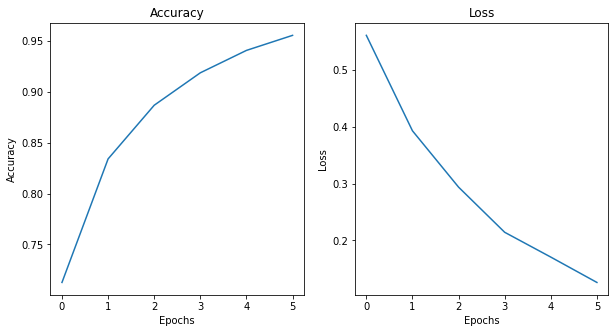

In [22]:
#KPI of model

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.plot(history.history["accuracy"])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")

ax2.plot(history.history["loss"])
ax2.set_title("Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
plt.show()